##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Variational Autoencoder

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/cvae">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/cvae.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/cvae.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This notebook demonstrates how to train a Variational Autoencoder (VAE) ([1](https://arxiv.org/abs/1312.6114), [2](https://arxiv.org/abs/1401.4082)) on the MNIST dataset. A VAE is a probabilistic take on the autoencoder, a model which takes high dimensional input data and compresses it into a smaller representation. Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a probability distribution, such as the mean and variance of a Gaussian. This approach produces a continuous, structured latent space, which is useful for image generation.

![CVAE image latent space](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cvae_latent_space.jpg?raw=1)

## Setup

In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
from tensorflow.keras.layers import *

## Load the MNIST dataset
Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. Model each pixel with a Bernoulli distribution in our model, and statically binarize the dataset.

In [4]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [6]:
train_size = 60000
batch_size = 16
test_size = 10000

## Use *tf.data* to batch and shuffle the data

In [9]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

# Defining Model

In [10]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
           tf.keras.layers.LSTM(latent_dim + latent_dim, input_shape=(28, 28)),
           #tf.keras.layers.Flatten(),
            # No activation
            #tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  """def encode(self, x):
    #print(model.encode(x))
    enc_output, enc_hidden = self.encoder(x)
    return enc_output, enc_hidden"""

  def save(self):
    self.encoder.save('encoder')
    self.decoder.save('decoder')

  def set(self, encoder, decoder):
    self.encoder = encoder
    self.decoder = decoder

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):#
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [ ]:
#prob_a = tf.nn.softmax(a)
#cr_aa = tf.nn.softmax_cross_entropy_with_logits(prob_a, a)
#cr_ab = tf.nn.softmax_cross_entropy_with_logits(prob_a, b)
#kl_ab = tf.reduce_sum(cr_ab - cr_aa)

# Defining Loss Functions

In [11]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def klx(true_p, q):
    #plogp-plogq
    loss_1 = -tf.nn.sigmoid_cross_entropy_with_logits(logits=true_p, labels = true_p)
    loss_2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=q, labels = true_p)   
    loss = loss_1 + loss_2
    return loss

def klx_v2(true_p, q):
  prob_a = tf.nn.softmax(true_p)
  cr_aa = tf.nn.softmax_cross_entropy_with_logits(prob_a, true_p)
  cr_ab = tf.nn.softmax_cross_entropy_with_logits(q, true_p)
  return tf.reduce_sum(cr_ab - cr_aa)


def klx_v3(true_p, q):
    #plogp-plogq
    true_prob = tf.nn.sigmoid(true_p)
    loss_1 = -tf.nn.sigmoid_cross_entropy_with_logits(logits=true_p, labels = true_prob)
    loss_2 = tf.nn.sigmoid_cross_entropy_with_logits(logits=q, labels = true_prob)   
    loss = loss_1 + loss_2
    return loss



def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


"""def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)"""


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  kl = tf.keras.losses.KLDivergence()
  logpx_z = tf.reduce_sum(kl(x, x_logit))
  bce = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.SUM)
  loss = bce(x, x_logit)
  return tf.reduce_mean(loss + 0.01*logpx_z), loss, logpx_z#0.01*

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss, bce, kl_loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Initializing training parameters and model

In [12]:
epochs = 60
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [13]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(int(predictions.shape[0])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [14]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

# Training

Epoch: 10, Test set ELBO: 3043.556396484375, time elapse for current epoch: 327.1728436946869


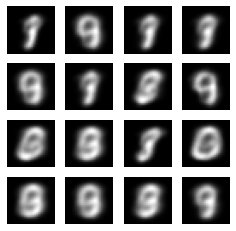

In [16]:
#training step

generate_and_save_images(model, 0, test_sample)

train_bce = []
test_bce = []

train_kl = []
test_kl = []

train_loss = []
test_loss = []

for epoch in range(1, epochs + 1):
  loss_train = tf.keras.metrics.Mean()
  loss_test = tf.keras.metrics.Mean()
  kl_train = tf.keras.metrics.Mean()
  kl_test = tf.keras.metrics.Mean()
  bce_train = tf.keras.metrics.Mean()
  bce_test = tf.keras.metrics.Mean()

  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
    ls, bce, kl = compute_loss(model, train_x)

    loss_train(ls)
    kl_train(kl)
    bce_train(bce)

  model.save()
  
  end_time = time.time()

  train_loss.append(loss_train.result())
  train_kl.append(kl_train.result())
  train_bce.append(bce_train.result())

  
  for test_x in test_dataset:
    ls, bce, kl = compute_loss(model, test_x)

    loss_test(ls)
    kl_test(kl)
    bce_test(bce)

  elbo = loss_test.result()

  test_loss.append(elbo)
  test_kl.append(kl_test.result())
  test_bce.append(bce_test.result())

  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

# Organizing and Plotting Losses

In [ ]:
train_bce_np = [x.numpy() for x in train_bce]
test_bce_np = [x.numpy() for x in test_bce]


train_kl_np = [x.numpy() for x in train_kl]#*(-1)
test_kl_np = [x.numpy() for x in test_kl]#*(-1)

train_loss_np = [x.numpy() for x in train_loss]
test_loss_np = [x.numpy() for x in test_loss]

In [ ]:
import pandas as pd
losses = []

losses.append(train_bce_np)
losses.append(test_bce_np)

losses.append(train_kl_np)
losses.append(test_kl_np)

losses.append(train_loss_np)
losses.append(test_loss_np)

numpy_array = np.array(losses)
transpose = numpy_array.T

transpose_list = transpose.tolist()

df = pd.DataFrame(transpose_list, columns = ["train_bce", "test_bce", "train_kl", "test_kl", "train_loss", "test_loss"])
df["epochs"] = range(0,60)

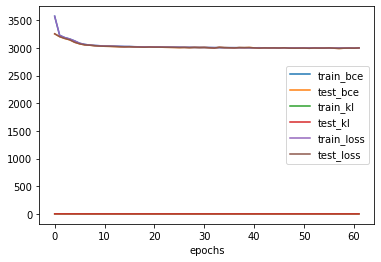

In [ ]:
df.plot(x="epochs", y=["train_bce", "test_bce", "train_kl", "test_kl", "train_loss", "test_loss"], kind="line")

### Display  generated images from random vectors and the latest saved model

In [ ]:

def plot_random_latent_images(model, latent_dim, digit_size=28):

  encoder = tf.keras.models.load_model('encoder')
  decoder = tf.keras.models.load_model('decoder')

  model.set(encoder, decoder)

  saved_images = []

  for i in range(100):
    z = np.load(f"random_{i}.npy")
    x_decoded = model.sample(z)
    digits = tf.reshape(x_decoded[0], (digit_size, digit_size))
    saved_images.append(digits.numpy())

    if i == 0:
            data = digits.numpy()
    else:
            data = np.concatenate((data, digits.numpy()), axis=0)
  
  fig = plt.figure(figsize=(10, 10))

  for i, x in enumerate(saved_images):
    plt.subplot(10, 10, i + 1)
    plt.imshow(x, cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('random.png'.format(epoch))
  plt.show()

  return data
  
    


In [ ]:
# evaluation step

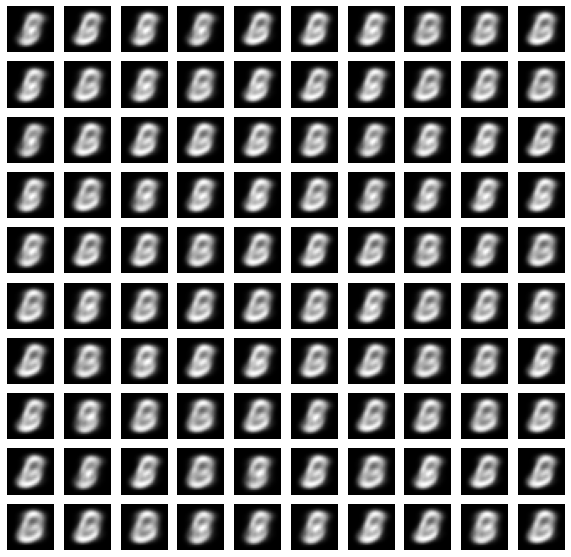

In [ ]:
fake_imgs = plot_random_latent_images(model, latent_dim = latent_dim, digit_size=28)

# Incepcion Score Calculation

In [ ]:

fake_imgs=fake_imgs.reshape(100,1,28,28)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs
    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    conv = nn.Conv2d(1, 3, 1).type(dtype)

    def get_pred(x):
        x = up(x)
        x = conv(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

In [ ]:
print("Calculating Inception Score...")
print(inception_score(fake_imgs, cuda=False, batch_size=32, resize=True, splits=10))
#(1.1467714278417795, 0.033706062420862874)

Calculating Inception Score...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


(1.1467714278417795, 0.033706062420862874)


In [ ]:
!pwd

/content


In [ ]:
!zip -r /content/file.zip /content/

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/.metricsUUID (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/.feature_flags_config.yaml (deflated 23%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/.last_update_check.json (deflated 24%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2022.05.03/ (stored 0%)
  adding: content/.config/logs/2022.05.03/13.41.59.446937.log (deflated 86%)
  adding: content/.config/logs/2022.05.03/13.41.39.801080.log (deflated 54%)
  adding: content/.config/logs/2022.05.03/13.41.17.129790.log (deflated 91%)
  adding: content/.config/logs/2022.05.03/13.42.27.306713.log (deflated 55%)
  a

In [ ]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>